## Import Libraries

In [262]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Create Models

Sentiment Analysis Model. Includes vocabulary embedding, LSTM layers and Linear layers.

In [284]:
class SentientAnalizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_dim):
        super(SentientAnalizer, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.Vocab_Embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=2, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self,x, hidden):
        emb = self.Vocab_Embedding(x).view(x.shape[0],x.shape[1],-1)
        #print (emb.shape)
        #print (hidden[0].shape)
        out, hidden = self.LSTM(emb, hidden)
        out = self.Linear1(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

Price Prediction Model. Includes attention layer to understand the news sentiment and context, LSTM layers and Linear layers. Takes 9 variables and the sentiment output as inputs, and outputs the 9 variables for the next step (next day).

In [285]:
class StockPredictor(nn.Module):

    def __init__(self, input_size_stock,input_size_sentiment, hidden_size, num_layers, max_length):
        super(StockPredictor, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size_stock = input_size_stock
        self.input_size_sentiment = input_size_sentiment
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn_hidd = nn.Linear(self.hidden_size, max_length)
        self.attn_out = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.CombinedLayerSS = nn.Linear(self.input_size_stock+self.input_size_sentiment, self.hidden_size)
        self.LSTM = nn.LSTM(self.input_size_sentiment+self.input_size_stock, self.hidden_size,num_layers=num_layers, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.input_size_stock)


    def forward(self,x, hidden, stock_news):
        attn_wights = F.softmax(self.attn_hidd(hidden[0][0]), dim=1)
        context = torch.bmm(attn_wights.unsqueeze(0), stock_news.unsqueeze(0))
        x_SS = torch.cat((x,context),dim=2)
        out, hidden = self.LSTM(x_SS, hidden)
        out = self.Linear1(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

## Load Data

In [367]:
news_1 = pd.read_csv('../data/Preprocess/final_data/Crypto_Currency_News.csv') # news_np[0]
news_2 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrencies.csv') # news_np[1]
news_3 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrency.csv') # news_np[2]
news_4 = pd.read_csv('../data/Preprocess/final_data/Cryptomarkets.csv') # news_np[3]
news_5 = pd.read_csv('../data/Preprocess/final_data/eth.csv') # news_np[4]
news_6 = pd.read_csv('../data/Preprocess/final_data/ethfinance.csv') # news_np[5]
news_7 = pd.read_csv('../data/Preprocess/final_data/ethtrader.csv') # news_np[6]

stocks_norm = pd.read_csv('../data/Preprocess/final_data/finance_norm.csv')


news_dfs = [news_1, news_2, news_3, news_4, news_5, news_6, news_7]
col_names = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']

# import scaler
with open('../data/Preprocess/scaler.pkl', 'rb') as f:
    scaler = pkl.load(f)

In [165]:
news_1.head(1)

,date,tok_text_1,tok_text_2,tok_text_3,tok_text_4,tok_text_5,tok_text_6,tok_text_7,tok_text_8,tok_text_9,tok_text_10
0,1/10/2019,"[1, 60, 61, 62, 63, 64, 65, 66, 67, 60, 63, 62...","[1, 93, 94, 60, 95, 96, 60, 84, 97, 98, 99, 10...","[1, 110, 111, 112, 113, 114, 84, 19, 56, 115, ...","[1, 120, 121, 43, 122, 123, 124, 125, 67, 126,...","[1, 5, 10, 127, 129, 119, 67, 130, 131, 132, 1...","[1, 136, 137, 138, 139, 140, 141, 2, 0, 0, 0, ...","[1, 142, 143, 144, 145, 2, 0, 0, 0, 0, 0, 0, 0...","[1, 147, 148, 149, 67, 126, 150, 2, 151, 2, 0,...","[1, 29, 152, 153, 154, 2, 0, 0, 0, 0, 0, 0, 0,...","[1, 13, 155, 49, 84, 156, 2, 0, 0, 0, 0, 0, 0,..."


##### Reshape & Transform data to numpy

In [368]:
'''
example of cell in news_1:
'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]'
is saved as a string
'''
# change type
import ast
for df in news_dfs:
    for j in range(1,11):        
        df['tok_text_'+str(j)] = np.array(df['tok_text_'+str(j)].apply(lambda x: ast.literal_eval (x)))

In [369]:
# convert all dataframes to numpy
# news_1_np = news_1.to_numpy()
news_np = []
for df in news_dfs:
    news_np.append(df.to_numpy())

stocks_norm_np = stocks_norm.to_numpy()

# delete 1st column
# news_1_np = news_1_np[:,1:]
for i in range(len(news_np)):
    news_np[i] = np.delete(news_np[i], 0, 1)
stocks_norm_np = stocks_norm_np[:,1:]

# reshape from (n,10) lists to (n,10,15) numbers
for k in range(len(news_np)):
    news_np[k] = np.array([np.array([np.array(news_np[k][i][j]) for j in range(10)]) for i in range(news_np[k].shape[0])])

# print
for i in range(len(news_np)):
    print(news_np[i].shape)
print (stocks_norm_np.shape)
# print first row, already checked it is the first row from the CSVs
# print (news_np[0][0])
# print(stocks_norm_np[0])

(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 9)


##### Make dataset
Data is split in 1089 days for training and 7 days for testing. The test samples are the last 7 days of the dataset. For the nature of this problem, the volatility of cryptocurrency prices, and the unavailability of news of the future, the objective is to forecast up to a week ahead with a decent accuracy.

In [394]:
# shape dataset to pytorch dataset class    
class Dataset (torch.utils.data.Dataset):
    def __init__(self, data_stock, notice, target):
        self.data = data_stock.unsqueeze(1)
        self.notice = notice.unsqueeze(3)
        self.target = target.unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.notice[idx], self.target[idx]

# split dataset into train and test
# using news_1 and stocks_norm, use all except one week, we will predict this week in testing
# data_stock = torch.Tensor(stocks_norm_np[:,:]).float()
data_stock = torch.Tensor(stocks_norm_np[:-7,:]).float()
test_stock = data_stock[-1] # we will start forcast from the real value of the last day of the train set
test_stock = test_stock.unsqueeze(0).unsqueeze(0)
# data_news = torch.Tensor(news_np[0]).long() 
data_news = torch.Tensor(news_np[0][:-7,:,:]).long() # news_np[0] is news_1 (Crypto_Currency_News.csv), change to others as needed
target = data_stock[1:,:]
data_stock = data_stock[:-1,:]
print (data_stock.shape, data_news.shape, target.shape)

# create dataset
dataset = Dataset(data_stock, data_news, target)

torch.Size([1088, 9]) torch.Size([1089, 10, 15]) torch.Size([1088, 9])


## Start Model

Create model for Sentiment Analysis and Price Prediction

In [269]:
Senti = SentientAnalizer(1, 128, 256, 50000, 128) # 50000 is the size of the vocabulary, our dictionary has 49783 words
Stock = StockPredictor(9,256,256,9,10) # 9 is the number of variables in the stock

In [270]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

Optimizer adds Senti parameters and Stock parameters so that they are trained together.

In [271]:
# optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.01) # lr=0.001
# loss function
criterion = nn.MSELoss()

Test everything works:

In [197]:

# test the dataloader
# for i, (data_stock, data_news, target) in enumerate(train_loader):
#     print (data_stock.shape, data_news.shape, target.shape)
#     # Test the model
#     data_news = data_news.squeeze(0)
#     hidde_senti = Senti.init_hidden(data_news.shape[0])
#     out_senti, hidden_senti = Senti(data_news, hidde_senti)
#     out_senti = out_senti[:,-1,:]
#     hidde_stock = Stock.init_hidden(data_stock.shape[0])
#     out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
#     print (out_stock.shape)
#     # Test the optimizer
#     optimizer.zero_grad()
#     loss = criterion(out_stock, target)
#     print(loss.item())
#     loss.backward()
#     optimizer.step()
#     break

In [57]:
# Test predict the next 5 days
# for i in range(5):    
#     out_stock, hidden_stock = Stock(out_stock, hidde_stock, out_senti)
#     print (out_stock.shape)

## Train Model

In [272]:
# train
epochs = 5 # 50 is overkill, do what you want
# array to store predictions
preds = []
for epoch in range(epochs):
    epoch_loss = 0
    e_preds = []
    hidde_senti = Senti.init_hidden(10)
    hidde_stock = Stock.init_hidden(1)
    print('-- Epoch', epoch+1, '--')
    for i, (data_stock, data_news, target) in enumerate(train_loader):
        data_news = data_news.squeeze(0)
        out_senti, hidden_senti = Senti(data_news, hidde_senti)
        out_senti = out_senti[:,-1,:]
        out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
        # store predictions
        e_preds.append(out_stock)
        # optimizer
        optimizer.zero_grad()   
        loss = criterion(out_stock, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i % 200 == 0: # 1096 steps
            print('Step:', i, ' Loss:', epoch_loss/(i+1))
            # print (i, epoch_loss/(i+1))
    preds.append(e_preds)
    print(epoch+1, '/', epochs, 'completed')
    print (epoch+1, 'Final Loss:', epoch_loss/(i+1), '\n')


-- Epoch 1 --
Step: 0  Loss: 0.086974136531353
Step: 200  Loss: 0.004912418822098502
Step: 400  Loss: 0.002878963660880158
Step: 600  Loss: 0.0055850431616456565
Step: 800  Loss: 0.005189047146572268
Step: 1000  Loss: 0.004930063455393902
1 / 5 completed
1 Final Loss: 0.004765586497888856 

-- Epoch 2 --
Step: 0  Loss: 0.1422528624534607
Step: 200  Loss: 0.00523173082094661
Step: 400  Loss: 0.0031084820176258466
Step: 600  Loss: 0.005799164281308728
Step: 800  Loss: 0.005306287458005955
Step: 1000  Loss: 0.005018054381953543
2 / 5 completed
2 Final Loss: 0.004835620034983175 

-- Epoch 3 --
Step: 0  Loss: 0.14171797037124634
Step: 200  Loss: 0.004915261802917163
Step: 400  Loss: 0.0029108725661729264
Step: 600  Loss: 0.005805675271497568
Step: 800  Loss: 0.005342385484974794
Step: 1000  Loss: 0.0050973680261905885
3 / 5 completed
3 Final Loss: 0.004916496890207528 

-- Epoch 4 --
Step: 0  Loss: 0.15209610760211945
Step: 200  Loss: 0.005168260253575777
Step: 400  Loss: 0.003056848362208

In [273]:
out_stock_n = out_stock.tolist()
target_n = target.tolist()
out_stock_n = out_stock_n[0][0]
target_n = target_n[0][0]
# unnormalize the data using loaded scaler
out_stock_n = scaler.inverse_transform([out_stock_n])
target_n = scaler.inverse_transform([target_n])

In [274]:
# pretty print
df_out = pd.DataFrame(out_stock_n[0])
df_target = pd.DataFrame(target_n[0])
df_out = df_out.T
df_target = df_target.T
df_out.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_target.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_out.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1309.791473,1.967346e+10,1.454706e+06,0.066762,354056.604871,0.200686,40015.159121,0.000337,17581.384982


In [275]:
df_target.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1328.25948,1.877111e+10,1.233506e+06,0.068807,345834.991741,0.2084,38467.999922,0.000382,42551.000134


## Save Model

In [276]:
# save model
torch.save(Senti.state_dict(), 'saved_models/Senti_28_03.pth')
torch.save(Stock.state_dict(), 'saved_models/Stock_28_03.pth')

## Load and Test Model

In [491]:
# load a model
Senti_l = SentientAnalizer(1, 128, 256, 50000, 128) 
Stock_l = StockPredictor(9,256,256,9,10) 

In [492]:
Senti_l.load_state_dict(torch.load('saved_models/Senti_28_03.pth'))
Stock_l.load_state_dict(torch.load('saved_models/Stock_28_03.pth'))

<All keys matched successfully>

In [493]:
preds_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
optimizer_l = torch.optim.Adam(list(Senti_l.parameters())+list(Stock_l.parameters()), lr=0.01) # lr=0.001
criterion = nn.MSELoss()

##### Make predictions for the 1088 days of training

In [494]:
# We set the model to evaluation mode
# This is important because some layers behave differently during training and evaluation
# We can set the model back to training mode by calling model.train()
Senti_l.eval()
Stock_l.eval()

StockPredictor(
  (attn_hidd): Linear(in_features=256, out_features=10, bias=True)
  (attn_out): Linear(in_features=512, out_features=256, bias=True)
  (CombinedLayerSS): Linear(in_features=265, out_features=256, bias=True)
  (LSTM): LSTM(265, 256, num_layers=9, batch_first=True)
  (Linear1): Linear(in_features=256, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=9, bias=True)
)

In [495]:
# Predict all the data

# with torch.no_grad(): # this breaks the model
preds_l = []
hidde_senti = Senti_l.init_hidden(10)
hidde_stock = Stock_l.init_hidden(1)
print('-- Predictions --')
for i, (data_stock, data_news, target) in enumerate(preds_loader):
    data_news = data_news.squeeze(0)
    out_senti, hidden_senti = Senti_l(data_news, hidde_senti)
    out_senti = out_senti[:,-1,:]
    out_stock, hidden_stock = Stock_l(data_stock, hidde_stock, out_senti)
    # store predictions
    preds_l.append(out_stock)
    # optimizer
    optimizer_l.zero_grad()   
    loss = criterion(out_stock, target)
    loss.backward()
    optimizer_l.step()
    if i % 200 == 0: # 1096 steps
        print('Step:', i)
print('-- Preds completed --')

-- Predictions --
Step: 0
Step: 200
Step: 400
Step: 600
Step: 800
Step: 1000
-- Preds completed --


##### Forecast the next 7 days

In [508]:
# import copy

fore_stock = test_stock # out_stock

# optimizer_fore = copy.deepcopy(optimizer_l)

We use torch.no_grad() to avoid tracking the gradients for the test set. We have already set the model to evaluation mode.

Here we take the last sentiment value and use it for the next 7 days, as we can't predict the sentiment for the future. 

For stock variables, we take the last prediction, and for each day of the forecast we take the output and use it as input for the next day.

In [509]:
# forcast the next 7 days
forecasts = []
forecasts.append(fore_stock) # add the start point
with torch.no_grad():
    for i in range(7):
        # predict the next day
        fore_stock, hidden_stock = Stock_l(fore_stock, hidde_stock, out_senti)
        optimizer_l.zero_grad()
        optimizer_l.step()
        forecasts.append(fore_stock)

In [510]:
print(forecasts)

[tensor([[[0.2590, 0.1721, 0.2131, 0.7292, 0.2517, 0.7149, 0.1028, 0.1254,
          0.2935]]]), tensor([[[0.1879, 0.1681, 0.2111, 0.6605, 0.2453, 0.8339, 0.0731, 0.2024,
          0.2412]]]), tensor([[[0.1845, 0.1737, 0.2088, 0.6598, 0.2444, 0.8435, 0.0722, 0.2129,
          0.2538]]]), tensor([[[0.1816, 0.1788, 0.2067, 0.6593, 0.2434, 0.8522, 0.0714, 0.2223,
          0.2652]]]), tensor([[[0.1789, 0.1834, 0.2048, 0.6589, 0.2425, 0.8599, 0.0706, 0.2309,
          0.2757]]]), tensor([[[0.1766, 0.1876, 0.2030, 0.6586, 0.2417, 0.8669, 0.0700, 0.2386,
          0.2852]]]), tensor([[[0.1745, 0.1915, 0.2014, 0.6584, 0.2409, 0.8731, 0.0694, 0.2456,
          0.2938]]]), tensor([[[0.1727, 0.1950, 0.1999, 0.6583, 0.2402, 0.8788, 0.0689, 0.2519,
          0.3016]]])]


In [499]:
# make forecast to numpy
forecast_mod = torch.cat(forecasts, dim=0)
# cant use forecast = forecast.detach().numpy() due to version issues, workaround:
forecast_mod = forecast_mod.tolist()
forecast_np = np.array(forecast_mod)
forecast_np = np.squeeze(forecast_np, axis=1)
# make preds to numpy
preds_mod = torch.cat(preds_l, dim=0)
preds_mod = preds_mod.tolist()
preds_np = np.array(preds_mod)
preds_np = np.squeeze(preds_np, axis=1)
real_values = stocks_norm_np[1:,:] # remove first row
print (forecast_np.shape)
print (preds_np.shape)
print (real_values.shape)

(8, 9)
(1088, 9)
(1095, 9)


In [500]:
# unnormalize the data using loaded scaler
real_values_un = scaler.inverse_transform(real_values)
preds_np_un = scaler.inverse_transform(preds_np)
forecast_np_un = scaler.inverse_transform(forecast_np)

## Results

In [501]:
# calculate standard deviation.
stds = []
for i in range(9):
    stds.append(np.std(real_values_un[:,i], axis=0))
for i in range(9):
    print (col_names[i], stds[i])

adj_close 1337.4726991204095
volume 10211521929.269737
num_trades_USDT 631839.7406452631
close_BTC 0.022021368239816732
num_trades_BTC 132399.17157028607
close_BNB 0.04479372888523323
num_trades_BNB 32263.902864333828
close_XRP 0.0004365633549043587
num_trades_XRP 12662.067767368158


Indicator of how well the model is doing:

In [502]:
# Our metric for evaluation will be how many predictions are within N standard deviations of the actual value
N = 0.3
# calculate how many predictions are within 0.3 standard deviations of the actual value
print("Predictions within 0.3 standard deviations of actual value:")
within_05 = []
for i in range(9):
    # within_05.append(np.sum(np.abs(preds_np_un[:,i] - real_values_un[:,i]) < N*stds[i]))
    within_05.append(np.sum(np.abs(preds_np_un[:,i] - real_values_un[:-7,i]) < N*stds[i]))

print (within_05)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_05[i]/1088*100))

# average of all
print ('Average: %.2f%%' % (np.sum(within_05)/1088/9*100))

Predictions within 0.3 standard deviations of actual value:
[983, 543, 585, 1020, 467, 868, 629, 1021, 585]
- adj_close: 90.35%
- volume: 49.91%
- num_trades_USDT: 53.77%
- close_BTC: 93.75%
- num_trades_BTC: 42.92%
- close_BNB: 79.78%
- num_trades_BNB: 57.81%
- close_XRP: 93.84%
- num_trades_XRP: 53.77%
Average: 68.43%


In [503]:
# same thinf but for the forecast
print("Forecast within 0.3 standard deviations of actual value:")
within_05 = []
for i in range(9):
    within_05.append(np.sum(np.abs(forecast_np_un[1:,i] - real_values_un[-7:,i]) < N*stds[i]))

print (within_05)
for i in range(9):
    print ('- %s: %.2f%%' % (col_names[i], within_05[i]/7*100))

# average of all
print ('Average: %.2f%%' % (np.sum(within_05)/7/9*100))

Forecast within 0.3 standard deviations of actual value:
[7, 5, 0, 7, 3, 2, 6, 7, 0]
- adj_close: 100.00%
- volume: 71.43%
- num_trades_USDT: 0.00%
- close_BTC: 100.00%
- num_trades_BTC: 42.86%
- close_BNB: 28.57%
- num_trades_BNB: 85.71%
- close_XRP: 100.00%
- num_trades_XRP: 0.00%
Average: 58.73%


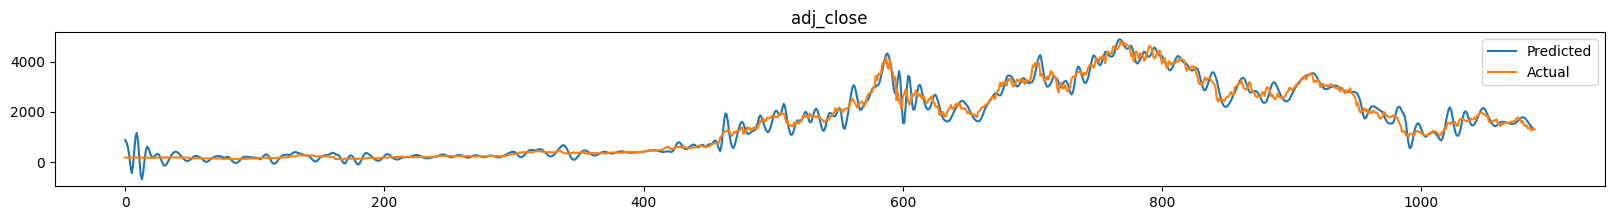

Last 5 predictions: 1527.81430, 1457.58835, 1394.24597, 1337.19476, 1298.50016
Last 5 actual: 1377.54138, 1324.38818, 1252.60779, 1327.68018, 1328.25952


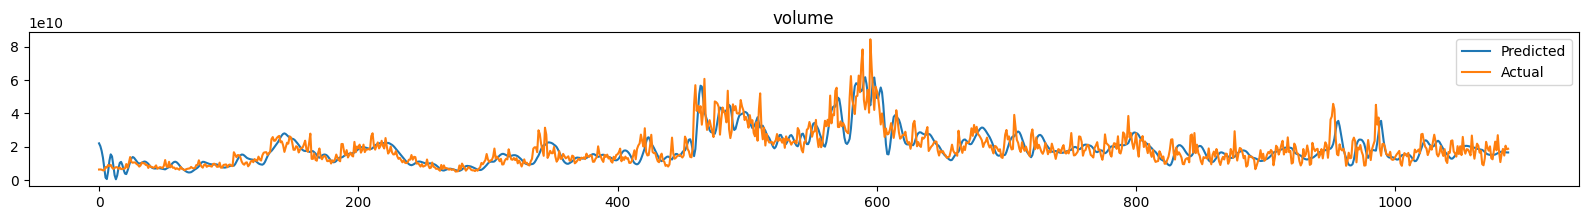

Last 5 predictions: 16954446540.12733, 16855264767.54282, 16683305223.17489, 16567847449.20066, 16574446083.87497
Last 5 actual: 18712714223.00000, 14722317220.00000, 20643507800.00000, 18461527259.00000, 18771106339.00000


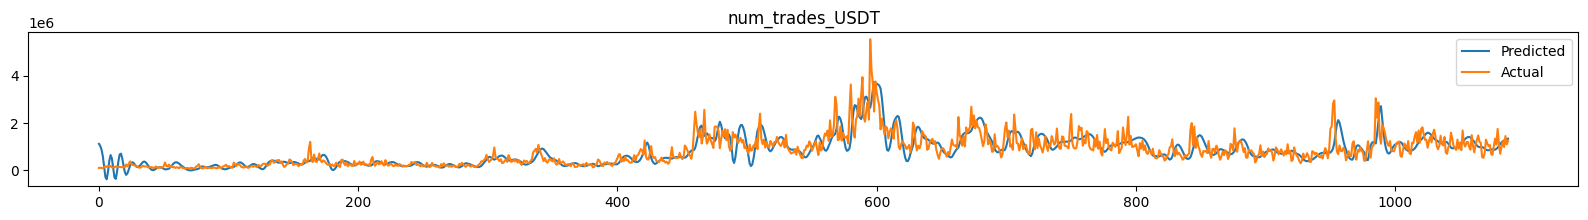

Last 5 predictions: 1225050.21056, 1263714.44927, 1288133.70609, 1318232.24183, 1334928.32653
Last 5 actual: 1235360.00000, 981235.00000, 1445950.00000, 1094636.00000, 1233506.00000


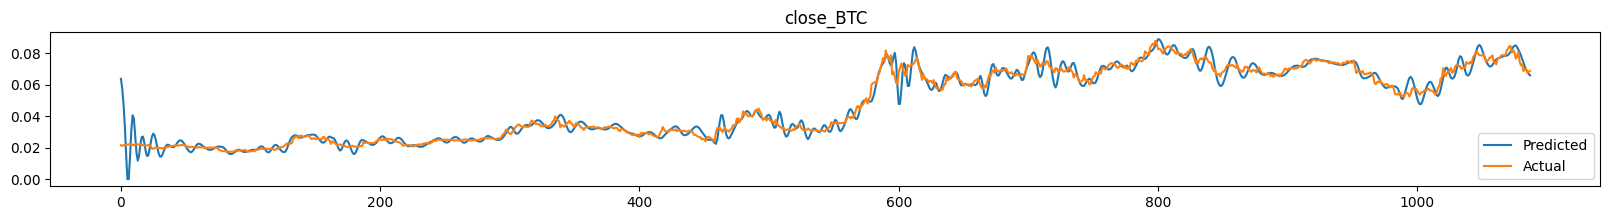

Last 5 predictions: 0.07158, 0.06965, 0.06809, 0.06690, 0.06599
Last 5 actual: 0.07043, 0.07010, 0.06749, 0.06836, 0.06881


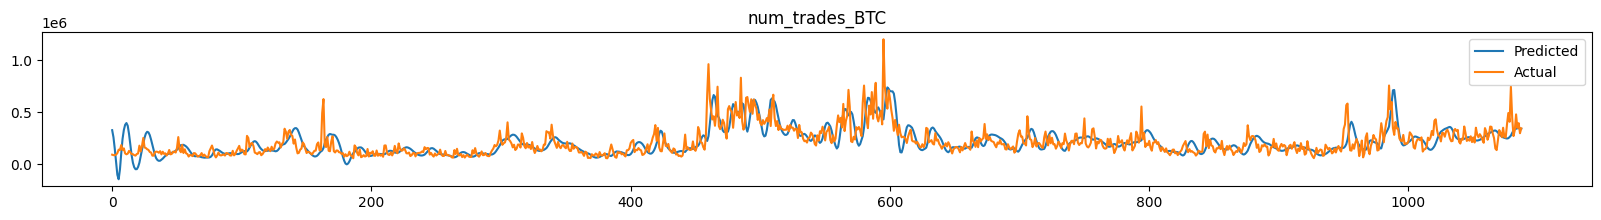

Last 5 predictions: 341561.29931, 346097.51742, 346773.93677, 345766.70235, 340447.59273
Last 5 actual: 479718.00000, 349851.00000, 395780.00000, 298574.00000, 345835.00000


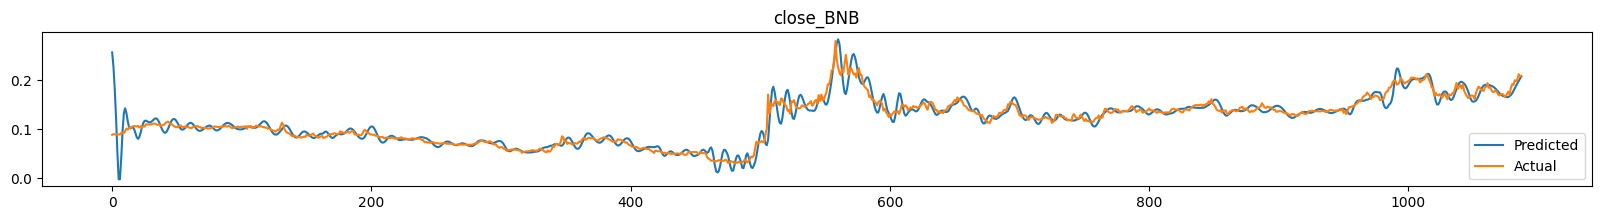

Last 5 predictions: 0.18834, 0.19321, 0.19781, 0.20266, 0.20733
Last 5 actual: 0.19770, 0.20120, 0.21190, 0.20750, 0.20840


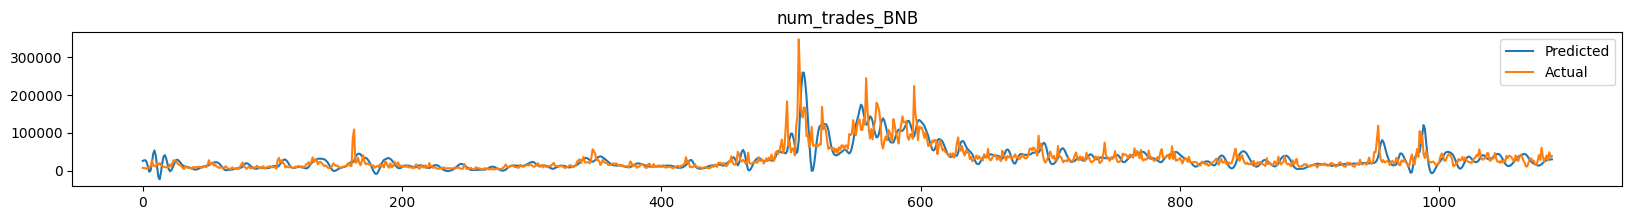

Last 5 predictions: 27470.45070, 28609.82150, 29040.33048, 29644.15703, 30080.42822
Last 5 actual: 40479.00000, 27456.00000, 48609.00000, 36084.00000, 38468.00000


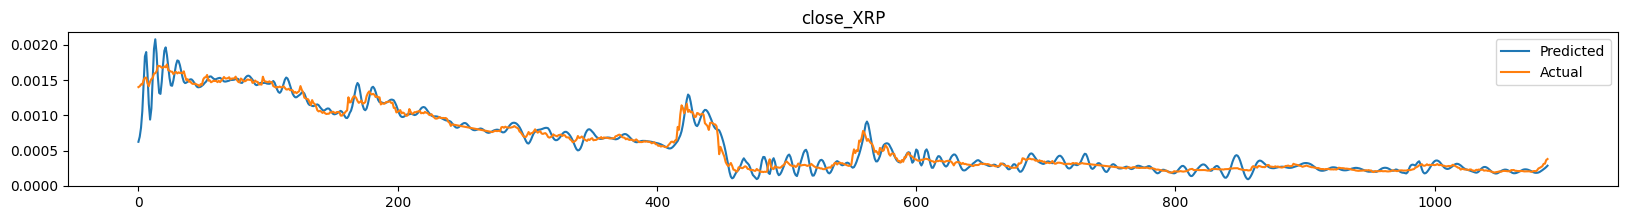

Last 5 predictions: 0.00022, 0.00024, 0.00025, 0.00027, 0.00029
Last 5 actual: 0.00028, 0.00031, 0.00032, 0.00037, 0.00038


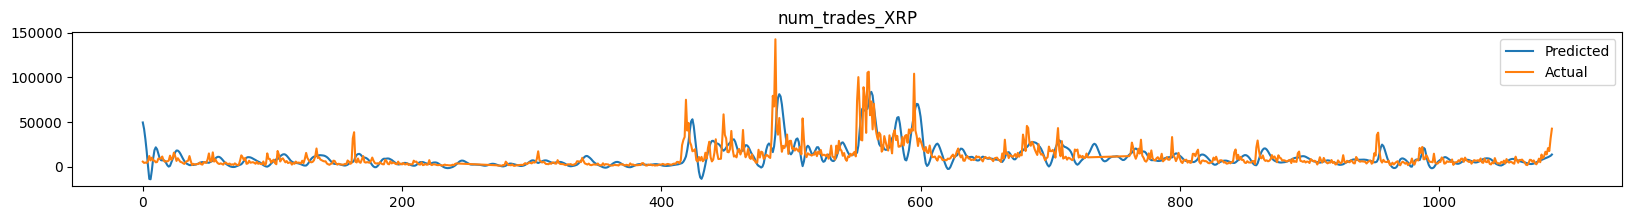

Last 5 predictions: 10136.79216, 10710.63840, 11446.07633, 12251.76793, 13667.20931
Last 5 actual: 13776.00000, 20779.00000, 17595.00000, 31514.00000, 42551.00000


In [482]:
# graph predictions vs actual
for i in range(9):
    plt.figure(figsize=(20,2))
    plt.plot(preds_np_un[:,i], label='Predicted')
    plt.plot(real_values_un[:-7,i], label='Actual')
    plt.legend()
    plt.title(col_names[i])
    plt.show()
    print ('Last 5 predictions: %.5f, %.5f, %.5f, %.5f, %.5f' % (preds_np_un[-5,i], preds_np_un[-4,i], preds_np_un[-3,i], preds_np_un[-2,i], preds_np_un[-1,i]))
    print ('Last 5 actual: %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values_un[-12,i], real_values_un[-11,i], real_values_un[-10,i], real_values_un[-9,i], real_values_un[-8,i]))


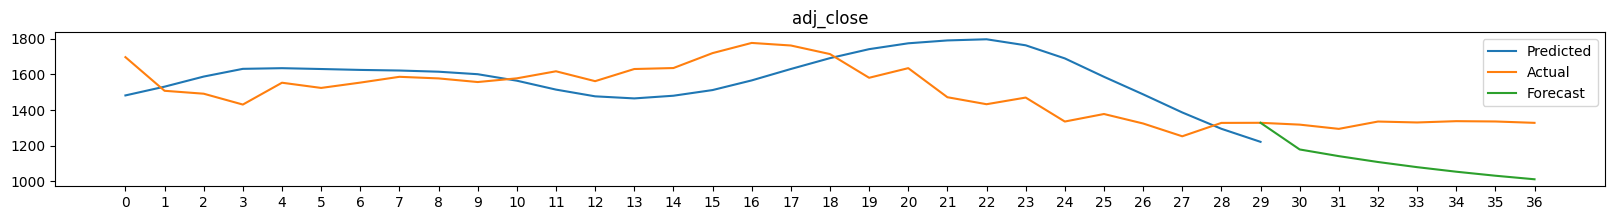

Last prediction: 1221.47842
Start: 1328.25952, Last week Real:     1317.99329, 1294.21680, 1335.32019, 1330.12769, 1337.41089, 1335.65234, 1327.97864
Start: 1328.25948, Last week Forecast: 1178.74150, 1141.28755, 1108.39610, 1079.45484, 1053.94248, 1031.41380, 1011.48761


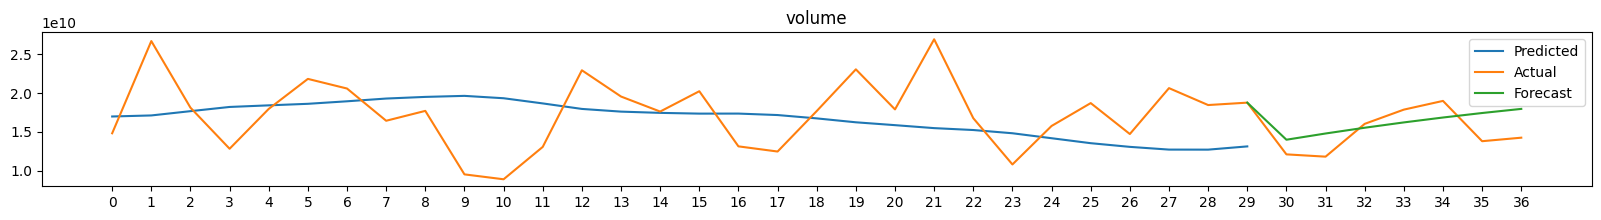

Last prediction: 13125268537.28126
Start: 18771106339.00000, Last week Real:     12098209717.00000, 11802651633.00000, 16034549271.00000, 17870598936.99999, 18994979566.00000, 13796915735.99999, 14250100092.99999
Start: 18771106610.65411, Last week Forecast: 13987860536.66493, 14790410164.66949, 15534042820.27193, 16220682858.84331, 16852806986.06707, 17433247919.28413, 17965041811.06825


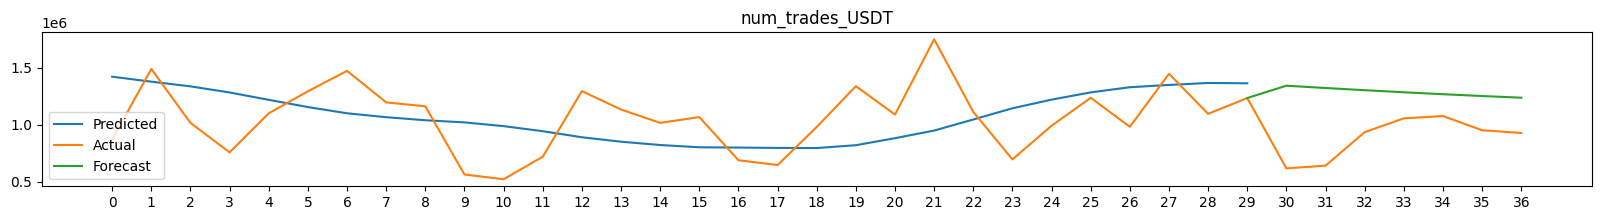

Last prediction: 1362547.64786
Start: 1233506.00000, Last week Real:     616390.00000, 640687.00000, 934159.00000, 1055212.00000, 1075441.00000, 950476.00000, 926935.00000
Start: 1233506.00043, Last week Forecast: 1341509.05625, 1321299.59344, 1302074.85386, 1283930.04106, 1266914.59550, 1251043.14501, 1236305.39290


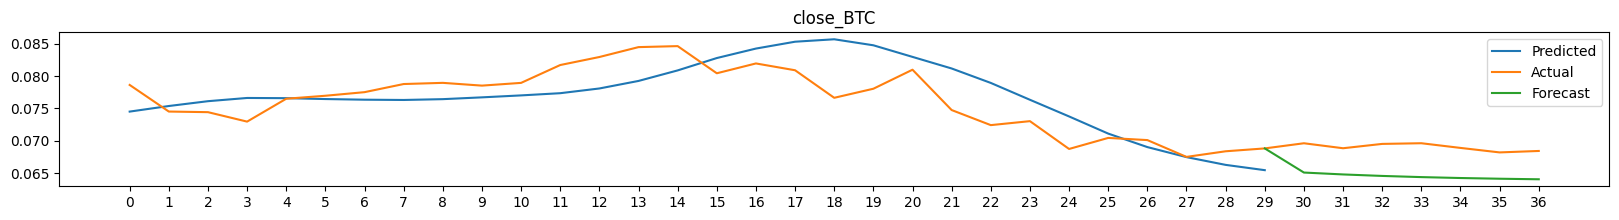

Last prediction: 0.06544
Start: 0.06881, Last week Real:     0.06961, 0.06883, 0.06950, 0.06961, 0.06888, 0.06819, 0.06841
Start: 0.06881, Last week Forecast: 0.06507, 0.06478, 0.06455, 0.06436, 0.06422, 0.06411, 0.06403


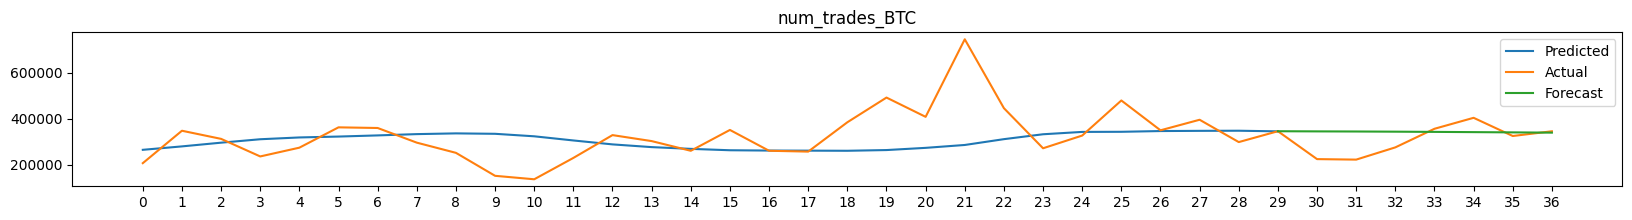

Last prediction: 345278.82850
Start: 345835.00000, Last week Real:     224423.00000, 222221.00000, 275490.00000, 356483.00000, 404236.00000, 325040.00000, 345607.00000
Start: 345834.99174, Last week Forecast: 345145.31661, 344646.06120, 343888.88045, 342957.48337, 341916.25760, 340814.29040, 339688.62296


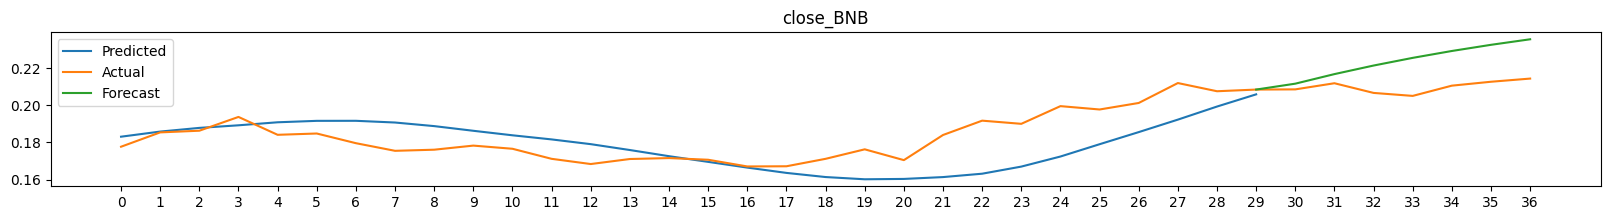

Last prediction: 0.20583
Start: 0.20840, Last week Real:     0.20850, 0.21180, 0.20660, 0.20500, 0.21050, 0.21260, 0.21430
Start: 0.20840, Last week Forecast: 0.21157, 0.21671, 0.22131, 0.22543, 0.22912, 0.23244, 0.23541


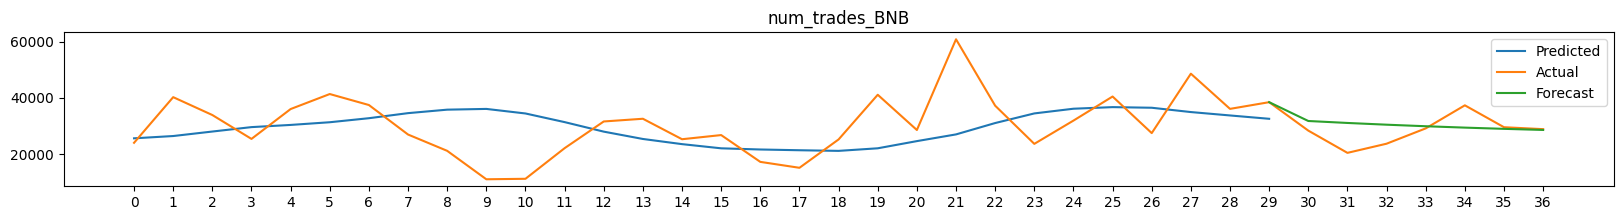

Last prediction: 32551.76143
Start: 38468.00000, Last week Real:     28343.00000, 20423.00000, 23684.00000, 29137.00000, 37346.00000, 29551.00000, 28865.00000
Start: 38467.99992, Last week Forecast: 31767.09593, 31070.52784, 30451.38926, 29900.42782, 29409.61184, 28971.94818, 28581.32332


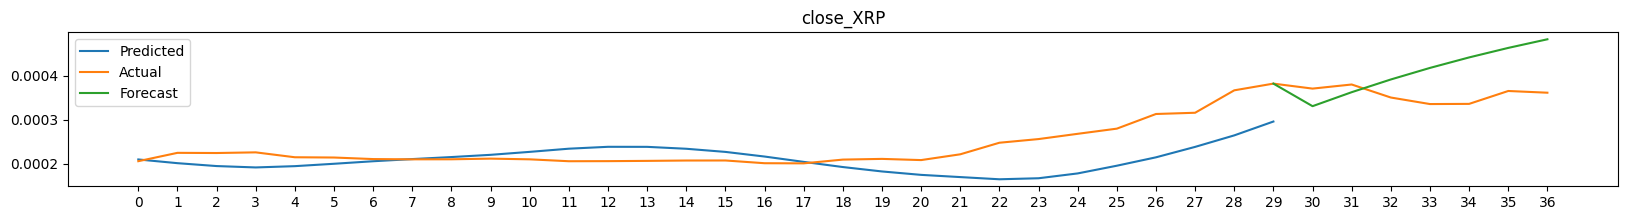

Last prediction: 0.00030
Start: 0.00038, Last week Real:     0.00037, 0.00038, 0.00035, 0.00034, 0.00034, 0.00036, 0.00036
Start: 0.00038, Last week Forecast: 0.00033, 0.00036, 0.00039, 0.00042, 0.00044, 0.00046, 0.00048


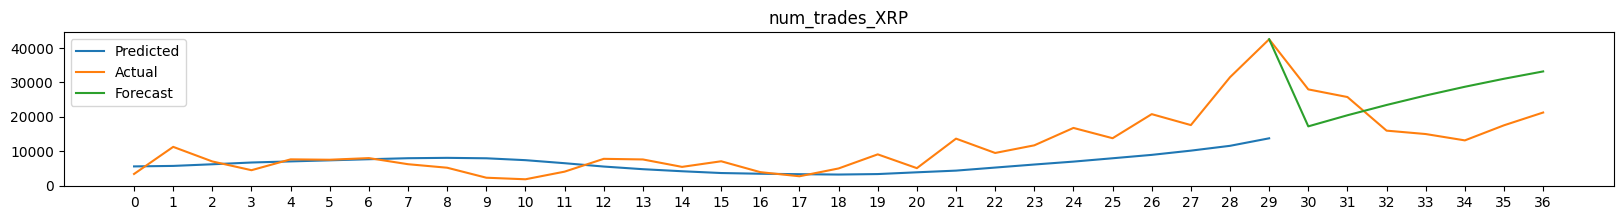

Last prediction: 13749.42310
Start: 42551.00000, Last week Real:     27979.00000, 25754.00000, 15980.00000, 14991.00000, 13145.00000, 17534.00000, 21250.00000
Start: 42551.00013, Last week Forecast: 17224.00321, 20453.42258, 23443.16228, 26201.72581, 28739.65375, 31068.78712, 33201.69411


In [504]:
# graph actual vs predictions + forecast
# only show the last 30 days + 7
for i in range(9):
    plt.figure(figsize=(20,2))
    plt.plot(preds_np_un[-30:,i], label='Predicted')
    plt.plot(real_values_un[-37:,i], label='Actual')
    plt.plot(np.arange(29,37), forecast_np_un[:,i], label='Forecast')
    plt.legend()
    plt.xticks(np.arange(0, 37, 1.0))
    plt.title(col_names[i])
    plt.show()
    print ('Last prediction: %.5f' % preds_np_un[-1,i])
    print ('Start: %.5f, Last week Real:     %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f' % (real_values_un[-8,i], real_values_un[-7,i], real_values_un[-6,i], real_values_un[-5,i], real_values_un[-4,i], real_values_un[-3,i], real_values_un[-2,i], real_values_un[-1,i]))
    print ('Start: %.5f, Last week Forecast: %.5f, %.5f, %.5f, %.5f, %.5f, %.5f, %.5f' % (forecast_np_un[0,i], forecast_np_un[1,i], forecast_np_un[2,i], forecast_np_un[3,i], forecast_np_un[4,i], forecast_np_un[5,i], forecast_np_un[6,i], forecast_np_un[7,i]))